# Wheat Grain Yield Analysis & Prediction
### Exploratory Data Analysis

**Correlation analysis between grain yield and variables: NDVI, EVI, MTCI**

Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

*Read dataset files*

In [3]:
robot = pd.read_excel(r"C:\Users\kevin\Downloads\robot.xlsx", engine="openpyxl") # Remote sensing UAV data
robot_agro = pd.read_excel(r"C:\Users\kevin\Downloads\robot_agro.xlsx", engine="openpyxl") # Physical wheat data

The NDVI-formula is:
$$NDVI = \frac{(NIR - Red)}{(NIR + Red)}$$

The MTCI-formula is:
$$MTCI = \frac{{(NIR - Red Edge)}}{(Red Edge - Red)}$$

The EVI-formula is:
$$EVI = 2.5 * \frac{{(NIR - Red)}}{NIR + (6*Red) - (7.5*Blue) + 1}$$

*The datasets do not contain NDVI, MTCI, and EVI. However, they contain the spectral bands necessary to calculate them by using the formulas above. I also need to put the <b>grain_yield_kg_daa</b> as a column into a new dataframe which should also have <b>NDVI</b>, <b>MTCI</b>, and <b>EVI</b> as columns. I can then use this dataframe to create a correlation heatmap.*

In [4]:
"""Calculating NDVI, MTCI, and EVI based on the spectral bands that are present in the dataset"""
robot['ndvi'] = (robot['nir'] - robot['red']) / (robot['nir'] + robot['red'])
robot['mtci'] = (robot['nir'] - robot['rededge']) / (robot['rededge'] - robot['red'])
robot['evi'] = 2.5 * ((robot['nir'] - robot['red']) / (robot['nir'] + (6*robot['red']) - (7.5*robot['blue']) + 1))

print(f"Number of unique dates: {robot['date'].nunique()}")

Number of unique dates: 25


*Creating a bar chart to illustrate the number of data points (rows) for each date in the dataset*

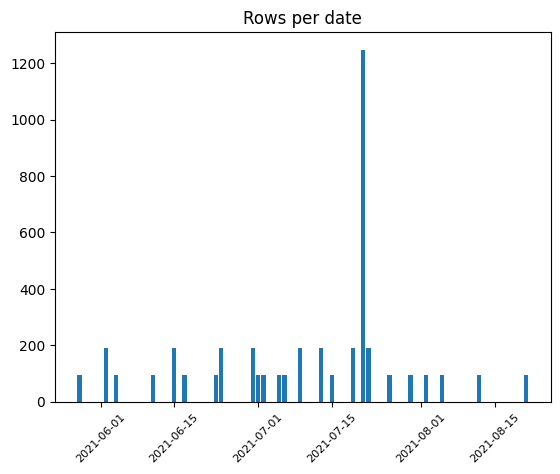

In [5]:
rows_per_date = robot.groupby('date').size().reset_index(name='row_count')

dates = rows_per_date['date']
counts = rows_per_date['row_count']

plt.title("Rows per date")
plt.bar(dates, counts)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [31]:
robot.info()
print("-----------------------------------------------------------------------------------------------------\n")
robot_agro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   entry          4320 non-null   int64         
 1   location       4320 non-null   object        
 2   season         4320 non-null   int64         
 3   camera         4320 non-null   object        
 4   fertilization  4320 non-null   object        
 5   plot_number    4320 non-null   int64         
 6   rep            4320 non-null   int64         
 7   block          4320 non-null   int64         
 8   col            4320 non-null   int64         
 9   row            4320 non-null   int64         
 10  date           4320 non-null   datetime64[ns]
 11  time           4320 non-null   object        
 12  blue           4320 non-null   float64       
 13  green          4320 non-null   float64       
 14  red            4320 non-null   float64       
 15  rededge        4320 n

*I need to use heading_dss (dss: days since sowing). I compute the average heading_dss for each season, and use this in order to find sowing date.*

In [7]:
mean_heading_dss = robot_agro.groupby('season')['heading_dss'].mean().reset_index(name='avg_heading_dss')
display(mean_heading_dss)

,season,avg_heading_dss
0,2016,53.520833
1,2017,50.145833
2,2019,62.937500
3,2020,61.093750
4,2021,62.833333


*I now plot the mean ndvi for each date in order to visualize and estimate the heading time period. We know that NDVI is at its peak around the heading date. Since I was asked to consider dates around the heading, I can based on this plot choose those dates where the NDVI is makredly higher than other dates, thereby these dates would be "around the heading." I choose <b>04.06.2021</b> to <b>19.07.2021</b> as the time interval which I can assume is around the heading.*

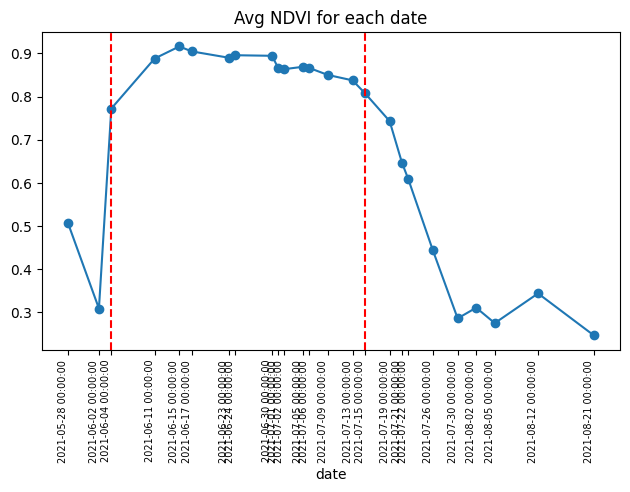

In [ ]:
mean_ndvi_per_dates = robot.groupby('date')['ndvi'].mean()
ax = mean_ndvi_per_dates.plot(marker='o')

above = mean_ndvi_per_dates > 0.75
if above.any():
    start_idx = above.idxmax()
    end_idx = above[::-1].idxmax()

    ax.axvline(start_idx, color='red', linestyle='--')
    ax.axvline(end_idx, color='red', linestyle='--')

ax.set_xticks(mean_ndvi_per_dates.index)
ax.set_xticklabels(mean_ndvi_per_dates.index, rotation=90, fontsize=7)
plt.tight_layout()
plt.title("Avg NDVI for each date")
plt.show()

(start_date, end_date) = (pd.to_datetime("04.06.2021", format="%d.%m.%Y"), pd.to_datetime("19.07.2021", format="%d.%m.%Y"))

*Extracting the agronomical data for season 2021 and imputing the missing (N/A) <b>grain_yield_kg_daa</b> values for season 2021 in agronomic data with the mean of the previous seasons.*

In [39]:
robot_agro_season_2021 = robot_agro[robot_agro['season'] == 2021]
robot_agro_season_2021['grain_yield_kg_daa'].fillna(robot_agro['grain_yield_kg_daa'].mean())

384    575.501114
385    575.501114
386    575.501114
387    575.501114
388    575.501114
          ...    
475    575.501114
476    575.501114
477    575.501114
478    575.501114
479    575.501114
Name: grain_yield_kg_daa, Length: 96, dtype: float64

In [ ]:
# Define predictors and target
predictors = ["ndvi", "mtci", "evi"]
target = ["grain_yield_kg_daa"]

mean_heading_dss = robot_agro.groupby('season')['heading_dss'].mean().reset_index(name='season')


sns.heatmap(robot.corr(), fmt=".2f")

ValueError: could not convert string to float: 'vollebekk'